# LJ Potential Benchmarking

Benchmarking TMol LJ-potential implementation.

In [4]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [5]:
import toolz
from toolz import first, merge

In [6]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [7]:
import tmol.tests.data

In [8]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [9]:
import tmol.score

In [10]:
import torch

In [11]:
import functools

In [12]:
decoys = tmol.tests.data.structures_bysize()

In [33]:
from itertools import product

import tmol.score.ljlk.numba_potential
import tmol.score.ljlk.cpp_potential

def benchmark_decoys(decoys):
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 400:
            continue 
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)
        ljlk_atom_types[score_graph.atom_types == None] = -1

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        ibd = score_graph.interblock_distance.min_dist[0]
        
        cpu_scores = {}
        
        for parallel, blocked in product((False,), (False,)):
            n = ".numba.cpu" + ("_parallel" if parallel else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked, impl="numba")
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords,
                    types,
                    path_length,

                    ljlk_resolver.pair_params.lj_sigma,
                    ljlk_resolver.pair_params.lj_switch_slope,
                    ljlk_resolver.pair_params.lj_switch_intercept,
                    ljlk_resolver.pair_params.lj_coeff_sigma12,
                    ljlk_resolver.pair_params.lj_coeff_sigma6,
                    ljlk_resolver.pair_params.lj_spline_y0,
                    ljlk_resolver.pair_params.lj_spline_dy0,

                    ljlk_resolver.global_params.lj_switch_dis2sigma,
                    ljlk_resolver.global_params.spline_start,
                    ljlk_resolver.global_params.max_dis,
                    parallel=parallel,
                    block_distances=ibd if blocked else None
                ).sum()
            cpu_scores[n] = score
            
        @make_subfixture(fixture, ".cpp.cpu", platform="cpu", parallel=False, blocked=False, impl="cpp")
        def score():
            return tmol.score.ljlk.cpp_potential.lj_intra(
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
            ).sum()
        cpu_scores["cpp.cpu"] = score
            
        logging.info(f"cpu: {cpu_scores}")
        
        score_graph_c = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system, device=torch.device("cuda"))
        ljlk_resolver_c = score_graph_c.param_resolver
        coords_c = score_graph_c.coords.detach()[0]
        types_c = types.cuda()
        path_length_c = path_length.cuda()
        ibd_c = score_graph_c.interblock_distance.min_dist[0]
                
        inputs = dict(
            atom_types = types_c,
            bonded_path_length = path_length_c,
        )
        preorg_inputs = {n : numba.cuda.as_cuda_array(p) for n, p in inputs.items() }
        
        params = dict(
          lj_sigma=           ljlk_resolver_c.pair_params.lj_sigma,
          lj_switch_slope=           ljlk_resolver_c.pair_params.lj_switch_slope,
          lj_switch_intercept=           ljlk_resolver_c.pair_params.lj_switch_intercept,
          lj_coeff_sigma12=           ljlk_resolver_c.pair_params.lj_coeff_sigma12,
          lj_coeff_sigma6=           ljlk_resolver_c.pair_params.lj_coeff_sigma6,
          lj_spline_y0=           ljlk_resolver_c.pair_params.lj_spline_y0,
          lj_spline_dy0=           ljlk_resolver_c.pair_params.lj_spline_dy0,
          lj_switch_dis2sigma=          ljlk_resolver_c.global_params.lj_switch_dis2sigma,
          spline_start=          ljlk_resolver_c.global_params.spline_start,
          max_dis=          ljlk_resolver_c.global_params.max_dis,
        )
        
        preorg_params = {n : numba.cuda.as_cuda_array(p) for n, p in params.items() }
        cuda_scores = {}
        
        for preorg, blocked in product((True, ), (False, )):
            n = ".numba_cuda" + ("_preorg" if preorg else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked)
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords_c,
                    **merge(inputs, preorg_params if preorg else params),
                    block_distances=ibd_c if blocked else None
                ).sum()
            cuda_scores[n] = score
            
        @make_subfixture(fixture, ".cpp.cuda", platform="cuda", blocked=False, impl="cpp")
        def score():
            return tmol.score.ljlk.cpp_potential.lj_intra(
                coords_c,
                **merge(inputs, params),
            ).sum()
        cuda_scores[".cpp.cuda"] = score
                
            
        logging.info(f"cuda_scores: {cuda_scores}")
        
    return stats

In [34]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu: {'.numba.cpu': tensor(-84.5055), 'cpp.cpu': tensor(-84.5055)}
INFO:root:cuda_scores: {'.numba_cuda_preorg': tensor(-84.5055, device='cuda:0'), 'cpp.cuda': tensor(-84.5055, device='cuda:0')}
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu: {'.numba.cpu': tensor(-9.2401), 'cpp.cpu': tensor(-9.2401)}
INFO:root:cuda_scores: {'.numba_cuda_preorg': tensor(-9.2401, device='cuda:0'), 'cpp.cuda': tensor(-9.2401, device='cuda:0')}
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:cpu: {'.numba.cpu': tensor(-154.1009), 'cpp.cpu': tensor(-154.1009)}
INFO:root:cuda_scores: {'.numba_cuda_preorg': tensor(-154.1009, device='cuda:0'), 'cpp.cuda': tensor(-154.1009, device='cuda:0')}
INFO:root:BYSIZE_300_RES_6F8B
INFO:root:cpu: {'.numba.cpu': tensor(-214.8056), 'cpp.cpu': tensor(-214.8056)}
INFO:root:cuda_scores: {'.numba_cuda_preorg': tensor(-214.8056, device='cuda:0'), 'cpp.cuda': tensor(-214.8056, device='cuda:0')}
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:cpu: {'.numba.cp

In [38]:
import pandas
import seaborn
from matplotlib import pyplot

In [39]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpp.cpu'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

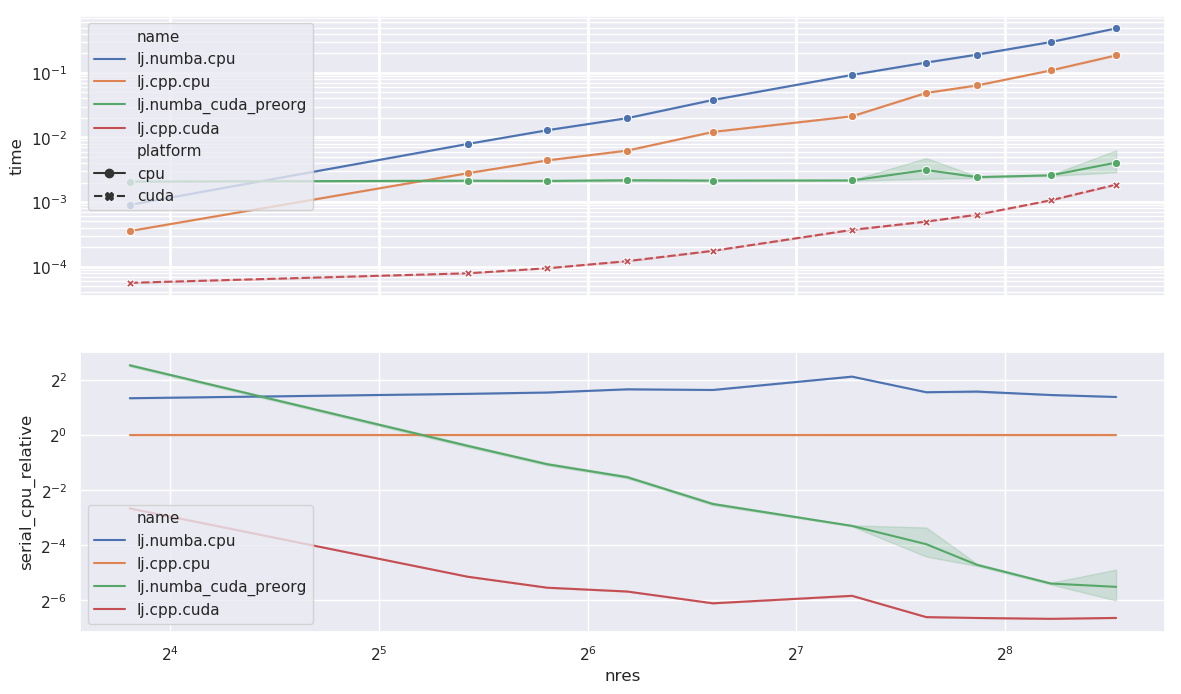

In [40]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers=True)

In [42]:
display(
    dat.query("name=='lj.cpp.cpu'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

display(
    dat.query("name=='lj.cpp.cuda'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14                   1.0  0.000356            2.359125  0.000840   
43                   1.0  0.002795            2.058646  0.005754   
56                   1.0  0.004412            1.448267  0.006389   
73                   1.0  0.006250            1.218350  0.007614   
97                   1.0  0.012144            1.100619  0.013366   
154                  1.0  0.021219            1.025507  0.021761   
197                  1.0  0.048784            1.011233  0.049332   
233                  1.0  0.063575            1.018461  0.064748   
298                  1.0  0.108778            1.001699  0.108962   
370                  1.0  0.185783            1.019384  0.189384   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.096179  0.000034  
43              0.063731  0.000178  
56              0.041890  0.000185  
73              0.026311  0.000164  
97              0.012784  0.000155  
154             0.004243  0.000090  
197             0.002680  0.000131  
233             0.005722  0.000364  
298             0.000815  0.000089  
370             0.014278  0.002653

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14              0.158027  0.000056            0.252989  0.000090   
43              0.028268  0.000079            0.038309  0.000107   
56              0.021433  0.000095            0.029878  0.000132   
73              0.019481  0.000122            0.024017  0.000150   
97              0.014475  0.000176            0.016628  0.000202   
154             0.017477  0.000371            0.040722  0.000864   
197             0.010223  0.000499            0.010576  0.000516   
233             0.010002  0.000636            0.010279  0.000654   
298             0.009789  0.001065            0.009892  0.001076   
370             0.010013  0.001860            0.010683  0.001985   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.003899  0.000001  
43              0.001481  0.000004  
56              0.000651  0.000003  
73              0.000248  0.000002  
97              0.000264  0.000003  
154             0.000665  0.000014  
197             0.000053  0.000003  
233             0.000047  0.000003  
298             0.000027  0.000003  
370             0.000313  0.000058